# COMP5318 Assignment 2

## Group members: 
## Liyang Han - 470324543 / Changhao Li - 480285090 / Yiran Zhao - 480500649

# 1. Import Libraries

In [1]:
import time
import os
import gzip
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import decomposition
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid, GridSearchCV

# 2. Loading data sets
### Loading function comes from
### https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

In [2]:
def load_mnist(path, kind='train'):
    '''
    Path is the folder which contains all four data sets
    '''
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

x_train, y_train = load_mnist('data', kind='train')
x_test, y_test = load_mnist('data', kind='t10k')

## Check if the dataset is loaded correctly and stores number of training set

In [3]:
print('Shape of training set is: ', x_train.shape)
print('Shape of training label is: ', y_train.shape)
print('Shape of test set is: ', x_test.shape)
print('Shape of test label is: ', y_test.shape)
num_train = x_train.shape[0]
print('Number of training sample is: ', num_train)

Shape of training set is:  (60000, 784)
Shape of training label is:  (60000,)
Shape of test set is:  (10000, 784)
Shape of test label is:  (10000,)
Number of training sample is:  60000


## Visualize the data

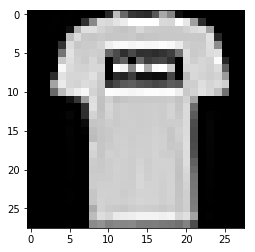

In [12]:
v = x_train[1]
v = v.reshape((28,28))
plt.imshow(v, cmap='gray')

## Disable future warning from package update

In [13]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Data preprocessing
### Here are two functions for:
### (1). Standardize training set and test set.
### (2). Normalization training set and test set.
### Another preprocessing method is PCA, but it will only use in SVM to reduce the time.

In [4]:
def standardize(data):
    data = preprocessing.scale(data)
    return data


def normalization(data):
    data = preprocessing.normalize(data)
    return data


In [5]:
x_train = normalization(standardize(x_train))
x_test = normalization(standardize(x_test))
print('The shape of training set after preprocessing is: ', x_train.shape)
print('The shape of test set after preprocessing is: ', x_test.shape)

The shape of training set after preprocessing is:  (60000, 784)
The shape of test set after preprocessing is:  (10000, 784)


# 3. Algorithms
### There are three algorithms: Random Forest, SVM and Logistic Regression
### Each of them contains hyperparameter tunning, 10-fold cross validation and confusion matrix.
### Validation test should be used only in evaluation. In testing, should use whole training set.

## 3.1 Generate Validation Set
### Validation set will be used in hyperparameter tunning and test model performace

In [16]:
n = x_train.shape[0]
X_train, X_valid, Y_train, Y_valid = train_test_split(x_train[:n,:], 
                                                      y_train[:n],
                                                      random_state=1)
print('X_train shape is: ', X_train.shape)
print('X_valid shape is: ', X_valid.shape)
print('Y_train shape is: ', Y_train.shape)
print('Y_valid shape is: ', Y_valid.shape)

X_train shape is:  (45000, 784)
X_valid shape is:  (15000, 784)
Y_train shape is:  (45000,)
Y_valid shape is:  (15000,)


## 3.2 Random Forest

### 3.2.1 Random Forest with all default parameters and cross validation

In [12]:
# Training
train_start_time = time.time()
rf_default = RandomForestClassifier()
rf_default.fit(X_train,Y_train)
train_end_time = time.time()
print('Training time is: ' + str(round(train_end_time - train_start_time, 4)) + 's')

# Prediction
pred_start_time = time.time()
pred_rf_default=rf_default.predict(X_valid)
pred_end_time = time.time()
print('Prediction time is: ' + str(round(pred_end_time - pred_start_time, 4)) + 's')

# Confusion Matrix
evaluation_start_time = time.time()
matrix_rf_default = confusion_matrix(Y_valid, pred_rf_default)
print('Confusion Matrix is\n{}'.format(matrix_rf_default))

# 10-Fold Cross Validation
rf_default_scores = cross_val_score(rf_default, X_train, Y_train, cv=10, scoring = 'accuracy')
print('10-fold CV accuracy: %.4f +/- %.4f' % (np.mean(rf_default_scores), np.std(rf_default_scores)))

# Precision, recall, etc
print(classification_report(Y_valid,pred_rf_default))

# Accuracy
acc_rf_default = accuracy_score(Y_valid, pred_rf_default)
evaluation_end_time = time.time()
print('Evaluation time is: ' + str(round(evaluation_end_time - evaluation_start_time, 4)) + 's')

Training time is: 13.2347s
Prediction time is: 0.0937s
Confusion Matrix is
[[1243    0   33   59    4    0   95    0   14    1]
 [  11 1485    7   30    2    0    7    0    2    0]
 [  25    2 1181   13  178    0  118    0   12    0]
 [  47   13   24 1331   48    1   25    0    3    0]
 [   6    5  176   73 1107    1   89    0    7    0]
 [   2    0    0    0    0 1410    0   58    5   29]
 [ 271    2  206   48  151    0  773    0   29    0]
 [   0    0    0    0    0   58    0 1400    2   70]
 [   4    1   13   10   11   11   21    3 1407    1]
 [   0    0    0    1    0   42    0   77    2 1404]]
10-fold CV accuracy: 0.8499 +/- 0.0045
              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1449
           1       0.98      0.96      0.97      1544
           2       0.72      0.77      0.75      1529
           3       0.85      0.89      0.87      1492
           4       0.74      0.76      0.75      1464
           5       0.93      0

### 3.2.2 Hyperparameter tunning in Random Forest

In [13]:
rf_default.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Use grid search. It will take a lot of time here.

In [14]:
'''
param_grid = {
    'min_samples_leaf': [5, 10, 20, 40],
    'max_depth': [20, 30, 40, 50],
    'n_estimators': [20, 30, 40],
    'max_features': ['sqrt', 'log2', 0.5, 0.6, 0.7],
    'n_jobs': [-1]
}
param_list = ParameterGrid(param_grid)
grid_search = GridSearchCV(rf_default, param_grid)
rf_gs = grid_search.fit(X_train, Y_train)
print('Grid in progress:\n')
means = rf_gs.cv_results_['mean_test_score']
stds = rf_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, rf_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) when %r" % (mean, std * 2, params))
print('The best choice is: ', rf_gs.best_params_)
'''

Grid in progress:

0.858 (+/-0.005) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 20, 'n_jobs': -1}
0.860 (+/-0.004) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 30, 'n_jobs': -1}
0.862 (+/-0.006) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 40, 'n_jobs': -1}
0.854 (+/-0.005) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 20, 'n_jobs': -1}
0.857 (+/-0.004) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 30, 'n_jobs': -1}
0.859 (+/-0.005) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'n_estimators': 40, 'n_jobs': -1}
0.847 (+/-0.005) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 20, 'n_jobs': -1}
0.849 (+/-0.004) when {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'n_estimators': 30, 'n_jobs': -1}
0.849 (+

#### The best choice is: {'max_depth': 40, 'max_features': 0.5, 'min_samples_leaf': 5, 'n_estimators': 40, 'n_jobs': -1}
#### But the max_features should be 'sqrt' to reduce the running time.
#### Thus, the choice is: {'max_depth': 40, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 40, 'n_jobs': -1}
#### Use this combination to run model again.

### 3.2.3 Random Forest with best hyperparameters

In [18]:
# Training
train_start_time = time.time()
rf_new = RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_leaf=5, n_estimators=40, n_jobs=-1)
rf_new.fit(X_train,Y_train)
train_end_time = time.time()
print('Training time is: ' + str(round(train_end_time - train_start_time, 4)) + 's')

# Prediction
pred_start_time = time.time()
pred_rf_new=rf_new.predict(X_valid)
pred_end_time = time.time()
print('Prediction time is: ' + str(round(pred_end_time - pred_start_time, 4)) + 's')

# Confusion Matrix
evaluation_start_time = time.time()
matrix_rf_new = confusion_matrix(Y_valid, pred_rf_new)
print('Confusion Matrix is\n{}'.format(matrix_rf_new))

# Accuracy
acc_lr_new = accuracy_score(Y_valid, pred_rf_new)

# 10-Fold Cross Validation
rf_new_scores = cross_val_score(rf_new, X_train, Y_train, cv=10, scoring = 'accuracy')
print('10-fold CV accuracy: %.4f +/- %.4f' % (np.mean(rf_new_scores), np.std(rf_new_scores)))

# Precision, recall, etc
print(classification_report(Y_valid,pred_rf_new))
evaluation_end_time = time.time()
print('Evaluation time is: ' + str(round(evaluation_end_time - evaluation_start_time, 4)) + 's')

Training time is: 7.6956s
Prediction time is: 0.149s
Confusion Matrix is
[[1235    1   32   64    7    1   98    0   11    0]
 [   5 1483    6   34    4    0   11    0    1    0]
 [   9    1 1187   18  200    2   96    0   16    0]
 [  40    5   13 1342   48    0   40    0    4    0]
 [   2    2  119   54 1198    1   80    0    8    0]
 [   0    0    0    0    0 1425    0   56    5   18]
 [ 239    2  173   44  151    0  835    0   36    0]
 [   0    0    0    0    0   26    0 1424    1   79]
 [   1    0    6   12   10    7   19    4 1422    1]
 [   0    0    0    0    0   21    0   65    1 1439]]
10-fold CV accuracy: 0.8677 +/- 0.0045
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1449
           1       0.99      0.96      0.98      1544
           2       0.77      0.78      0.77      1529
           3       0.86      0.90      0.88      1492
           4       0.74      0.82      0.78      1464
           5       0.96      0.9

#### Since the result is acceptable, this model will be used in testing.

### 3.2.4 Random Forest Testing

In [19]:
rf_tunned_start_time = time.time()
rf_tunned = RandomForestClassifier(max_depth=40, max_features='sqrt', min_samples_leaf=5, n_estimators=40, n_jobs=-1)
rf_tunned.fit(x_train, y_train)
rf_tunned_pred = rf_tunned.predict(x_test)
rf_tunned_acc = accuracy_score(y_test, rf_tunned_pred)
rf_tunned_matrix = confusion_matrix(y_test, rf_tunned_pred)
rf_tunned_end_time = time.time()

print('Accuracy is: '+ str(rf_tunned_acc))
print('Time is: ' + str(round(rf_tunned_end_time - rf_tunned_start_time, 4)) + 's')
print('Confusion_matrix is\n{}'.format(rf_tunned_matrix))
print(classification_report(y_test, rf_tunned_pred))

Accuracy is: 0.8629
Time is: 11.3588s
Confusion_matrix is
[[845   0  12  35   5   1  87   0  15   0]
 [  3 954   8  26   2   0   5   0   2   0]
 [ 13   0 784  10 123   0  60   0  10   0]
 [ 27   3   7 892  30   0  39   0   2   0]
 [  2   1  95  38 804   0  52   0   8   0]
 [  0   0   0   2   0 946   0  36   3  13]
 [164   1 121  34  94   0 559   0  27   0]
 [  0   0   0   0   0  17   0 939   0  44]
 [  0   2   7   5   6   2   7   4 965   2]
 [  0   0   0   0   0  13   0  44   2 941]]
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1000
           1       0.99      0.95      0.97      1000
           2       0.76      0.78      0.77      1000
           3       0.86      0.89      0.87      1000
           4       0.76      0.80      0.78      1000
           5       0.97      0.95      0.96      1000
           6       0.69      0.56      0.62      1000
           7       0.92      0.94      0.93      1000
           8       0.93 

## 3.3 Support Vector Machine
### SVM was done in another laptop. So the hyperparamter tunning results come from "Assign2_SVM.ipynb" file.
### The details can be found in "Assign2_SVM.ipynb" file.

### 3.3.1 PCA

In [17]:
pca = decomposition.PCA(n_components=37,copy=False)
x_train_svm_pca = pca.fit_transform(X_train)
x_valid_svm_pca = pca.transform(X_valid)
x_test_svm_pca = pca.transform(x_test)

print('x_train_svm_pca shape is: ', x_train_svm_pca.shape)
print('x_valid_svm_pca shape is: ', x_valid_svm_pca.shape)
print('x_test_svm_pca shape is: ', x_test_svm_pca.shape)

x_train_svm_pca shape is:  (45000, 37)
x_valid_svm_pca shape is:  (15000, 37)
x_test_svm_pca shape is:  (10000, 37)


### 3.3.2 SVM with all default parameters and cross validation

In [19]:
# Training
train_start_time = time.time()
svm_default = svm.SVC()
svm_default.fit(x_train_svm_pca,Y_train)
train_end_time = time.time()
print('Training time is: ' + str(round(train_end_time - train_start_time, 4)) + 's')

# Prediction
pred_start_time = time.time()
pred_svm_default=svm_default.predict(x_valid_svm_pca)
pred_end_time = time.time()
print('Prediction time is: ' + str(round(pred_end_time - pred_start_time, 4)) + 's')

# Confusion Matrix
evaluation_start_time = time.time()
matrix_svm_default = confusion_matrix(Y_valid, pred_svm_default)
print('Confusion Matrix is\n{}'.format(matrix_svm_default))

# 10-Fold Cross Validation
svm_default_scores = cross_val_score(svm_default, x_train_svm_pca, Y_train, cv=10, scoring = 'accuracy')
print('10-fold CV accuracy: %.4f +/- %.4f' % (np.mean(svm_default_scores), np.std(svm_default_scores)))

# Precision, recall, etc
print(classification_report(Y_valid,pred_svm_default))

# Accuracy
acc_svm_default = accuracy_score(Y_valid, pred_svm_default)
evaluation_end_time = time.time()
print('Evaluation time is: ' + str(round(evaluation_end_time - evaluation_start_time, 4)) + 's')

Training time is: 46.2276s
Prediction time is: 18.4341s
Confusion Matrix is
[[1183    2   13  141    3    3   84    0   20    0]
 [   4 1446   23   56    0    0   15    0    0    0]
 [  15    1  989   15  296    3  192    0   18    0]
 [  55   10    7 1302   56    0   54    0    7    1]
 [   2    1  111   70 1148    3  121    0    8    0]
 [   0    0    1    2    0 1328    1  119    5   48]
 [ 282    2  174   85  207    1  688    0   41    0]
 [   0    0    0    0    0  105    0 1316    2  107]
 [   2    0    3   18    7   18   31    9 1394    0]
 [   0    0    0    0    0   40    0   89    0 1397]]
10-fold CV accuracy: 0.8120 +/- 0.0043
              precision    recall  f1-score   support

           0       0.77      0.82      0.79      1449
           1       0.99      0.94      0.96      1544
           2       0.75      0.65      0.69      1529
           3       0.77      0.87      0.82      1492
           4       0.67      0.78      0.72      1464
           5       0.88      

### 3.3.3 Hyperparameter tunning in SVM

#### Detail progress can be found in "Assign2_SVM.ipynb" file.
#### The best choice is: {'C': 20, 'gamma': '1', 'kernel': 'rbf'}
#### Use this combination to run model again.

### 3.3.4 SVM with best hyperparameters

In [21]:
# Training
train_start_time = time.time()
svm_new = svm.SVC(C=20, gamma=1, kernel='rbf')
svm_new.fit(x_train_svm_pca,Y_train)
train_end_time = time.time()
print('Training time is: ' + str(round(train_end_time - train_start_time, 4)) + 's')

# Prediction
pred_start_time = time.time()
pred_svm_new=svm_new.predict(x_valid_svm_pca)
pred_end_time = time.time()
print('Prediction time is: ' + str(round(pred_end_time - pred_start_time, 4)) + 's')

# Confusion Matrix
evaluation_start_time = time.time()
matrix_svm_new = confusion_matrix(Y_valid, pred_svm_new)
print('Confusion Matrix is\n{}'.format(matrix_svm_new))

# 10-Fold Cross Validation
svm_new_scores = cross_val_score(svm_new, x_train_svm_pca, Y_train, cv=10, scoring = 'accuracy')
print('10-fold CV accuracy: %.4f +/- %.4f' % (np.mean(svm_new_scores), np.std(svm_new_scores)))

# Precision, recall, etc
print(classification_report(Y_valid,pred_svm_new))

# Accuracy
acc_svm_new = accuracy_score(Y_valid, pred_svm_new)
evaluation_end_time = time.time()
print('Evaluation time is: ' + str(round(evaluation_end_time - evaluation_start_time, 4)) + 's')

Training time is: 22.32s
Prediction time is: 9.549s
Confusion Matrix is
[[1255    1   30   37    4    1  116    0    5    0]
 [   4 1519    1   15    1    0    2    0    2    0]
 [  24    2 1242   14  142    0  101    0    4    0]
 [  37   19   11 1329   59    0   29    0    7    1]
 [   3    0  101   39 1238    1   79    0    3    0]
 [   0    0    0    0    0 1447    0   33    3   21]
 [ 203    2  115   35   98    0 1013    0   14    0]
 [   0    0    0    0    0   26    0 1450    1   53]
 [   6    1    7    8    5    6   15    3 1431    0]
 [   0    0    0    0    0   23    0   59    1 1443]]
10-fold CV accuracy: 0.8948 +/- 0.0035
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1449
           1       0.98      0.98      0.98      1544
           2       0.82      0.81      0.82      1529
           3       0.90      0.89      0.90      1492
           4       0.80      0.85      0.82      1464
           5       0.96      0.96

### 3.3.5 SVM Testing
#### Since the previous PCA is on splited training set, here also needs to do PCA on original training set.

In [9]:
pca_test = decomposition.PCA(n_components=37,copy=False)
x_train_svm_test_pca = pca_test.fit_transform(x_train) # Training set after PCA, which will be used only in testing.
x_test_svm_test_pca = pca_test.transform(x_test) # Test set after PCA, which will be used only in testing.
print('x_train_svm_test_pca shape is: ', x_train_svm_test_pca.shape)
print('x_test_svm_test_pca shape is: ', x_test_svm_test_pca.shape)

x_train_svm_test_pca shape is:  (60000, 37)
x_test_svm_test_pca shape is:  (10000, 37)


In [10]:
svm_test_start_time = time.time()
svm_new_tunned = svm.SVC(C=20, gamma=1, kernel='rbf')
svm_new_tunned.fit(x_train_svm_test_pca, y_train)
svm_test_pred = svm_new_tunned.predict(x_test_svm_test_pca)
svm_test_acc = accuracy_score(y_test, svm_test_pred)
svm_test_matrix = confusion_matrix(y_test, svm_test_pred)
svm_test_end_time = time.time()

print('Confusion_matrix is\n{}'.format(svm_test_matrix))
print(classification_report(y_test, svm_test_pred))
print('Prediction time is: ' + str(round(svm_test_end_time - svm_test_start_time, 4)) + 's')
print('Accuracy is: '+ str(svm_test_acc))

Confusion_matrix is
[[855   1  11  26   8   1  93   0   5   0]
 [  6 969   0  19   3   0   3   0   0   0]
 [ 18   2 842   8  70   0  58   0   2   0]
 [ 16   5  14 906  35   0  22   0   2   0]
 [  1   0 107  23 810   0  58   0   1   0]
 [  0   0   0   1   0 952   0  36   1  10]
 [143   0  88  27  68   1 663   0  10   0]
 [  0   0   0   0   0  11   0 981   0   8]
 [  3   1   9   7   2   4   2   5 967   0]
 [  0   0   0   0   0  14   1  89   0 896]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.84      0.81      1000
           3       0.89      0.91      0.90      1000
           4       0.81      0.81      0.81      1000
           5       0.97      0.95      0.96      1000
           6       0.74      0.66      0.70      1000
           7       0.88      0.98      0.93      1000
           8       0.98      0.97      0.97      1000
        

#### The results have slightly differences with those in "Assign2_SVM.ipynb" file. But it is in a normal margin of error.

## 3.4 Logistic Regression

### 3.4.1 PCA
#### Here is PCA on data sets which already splited in 3.1. Except test set.

In [9]:
pca = decomposition.PCA(n_components=150, copy=False)
x_train_lr_pca=pca.fit_transform(X_train)
x_valid_lr_pca=pca.transform(X_valid)
x_test_lr_pca=pca.transform(x_test)

print('x_train_lr_pca shape is: ', x_train_lr_pca.shape)
print('x_valid_lr_pca shape is: ', x_valid_lr_pca.shape)
print('x_test_lr_pca shape is: ', x_test_lr_pca.shape)

x_train_lr_pca shape is:  (45000, 150)
x_valid_lr_pca shape is:  (15000, 150)
x_test_lr_pca shape is:  (10000, 150)


### 3.4.2 Logistic regression with all default parameters and cross validation

In [12]:
# Training
train_start_time = time.time()
lr_default = LogisticRegression()
lr_default.fit(x_train_lr_pca,Y_train)
train_end_time = time.time()
print('Training time is: ' + str(round(train_end_time - train_start_time, 4)) + 's')

# Prediction
pred_start_time = time.time()
pred_lr_default=lr_default.predict(x_valid_lr_pca)
pred_end_time = time.time()
print('Prediction time is: ' + str(round(pred_end_time - pred_start_time, 4)) + 's')

# Confusion Matrix
evaluation_start_time = time.time()
matrix_lr_default = confusion_matrix(Y_valid, pred_lr_default)
print('Confusion Matrix is\n{}'.format(matrix_lr_default))

# 10-Fold Cross Validation
lr_default_scores = cross_val_score(lr_default, x_train_lr_pca, Y_train, cv=10, scoring = 'accuracy')
print('10-fold CV accuracy: %.4f +/- %.4f' % (np.mean(lr_default_scores), np.std(lr_default_scores)))

# Precision, recall, etc
print(classification_report(Y_valid,pred_lr_default))

# Accuracy
acc_lr_default = accuracy_score(Y_valid, pred_lr_default)
evaluation_end_time = time.time()
print('Evaluation time is: ' + str(round(evaluation_end_time - evaluation_start_time, 4)) + 's')

Training time is: 14.2286s
Prediction time is: 0.007s
Confusion Matrix is
[[1203    5   20   85    4    6  102    0   24    0]
 [   7 1487   11   28    6    1    3    1    0    0]
 [  25    5 1136   14  205   16  112    0   16    0]
 [  43   23   13 1290   60    7   44    0   10    2]
 [   2    0  125   55 1139   15  114    0   14    0]
 [   1    0    1    2    0 1357    0   89   14   40]
 [ 230    7  173   63  154   14  802    0   37    0]
 [   0    0    0    0    0   58    0 1387    3   82]
 [   3    0    7   21    9   16   24    8 1393    1]
 [   0    0    0    0    0   37    1   61    0 1427]]
10-fold CV accuracy: 0.8394 +/- 0.0047
              precision    recall  f1-score   support

           0       0.79      0.83      0.81      1449
           1       0.97      0.96      0.97      1544
           2       0.76      0.74      0.75      1529
           3       0.83      0.86      0.85      1492
           4       0.72      0.78      0.75      1464
           5       0.89      0.

### 3.4.3 Hyperparameter tunning in logistic regression

In [13]:
lr_default.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'warn',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'warn',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [14]:
'''
param_grid_lr = {
    'penalty': ['l1','l2'],
    'C': [0.1, 1, 10, 100, 1000],
    'multi_class': ['ovr', 'multinomial', 'auto'],
    'max_iter': [100, 600, 1000, 1200],
    'tol': [0.01, 0.02, 0.03],
    'n_jobs': [-1],
    'solver': ['saga']
}
param_list = ParameterGrid(param_grid_lr)
grid_search_lr = GridSearchCV(lr_default, param_grid_lr)
lr_gs = grid_search_lr.fit(x_train_lr_pca, Y_train)
print('Grid in progress:\n')
means = lr_gs.cv_results_['mean_test_score']
stds = lr_gs.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, lr_gs.cv_results_['params']):
    print("%0.3f (+/-%0.03f) when %r" % (mean, std * 2, params))
print('The best choice is: ', lr_gs.best_params_)
'''

Grid in progress:

0.805 (+/-0.007) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.01}
0.805 (+/-0.007) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.02}
0.805 (+/-0.006) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.03}
0.803 (+/-0.006) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
0.803 (+/-0.006) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.02}
0.803 (+/-0.005) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'ovr', 'n_jobs': -1, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.03}
0.813 (+/-0.006) when {'C': 0.1, 'max_iter': 100, 'multi_class': 'multinomial', 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.01}
0.813 (+/-0.005) when {'C': 0.1, 'm

#### The best choice is: {'C': 10, 'max_iter': 600, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l1', 'solver': 'saga', 'tol': 0.03}
#### Use this combination to run model again.

### 3.4.4 Logistic regression with best hyperparameters

In [15]:
# Training
train_start_time = time.time()
lr_new = LogisticRegression(C=10, max_iter=600, multi_class='auto', n_jobs=-1, penalty='l1', solver='saga', tol=0.03)
lr_new.fit(x_train_lr_pca,Y_train)
train_end_time = time.time()
print('Training time is: ' + str(round(train_end_time - train_start_time, 4)) + 's')

# Prediction
pred_start_time = time.time()
pred_lr_new=lr_new.predict(x_valid_lr_pca)
pred_end_time = time.time()
print('Prediction time is: ' + str(round(pred_end_time - pred_start_time, 4)) + 's')

# Confusion Matrix
matrix_lr_new = confusion_matrix(Y_valid, pred_lr_new)
print('Confusion Matrix is\n{}'.format(matrix_lr_new))


# 10-Fold Cross Validation
lr_new_scores = cross_val_score(lr_new, x_train_lr_pca, Y_train, cv=10, scoring = 'accuracy')
print('10-fold CV accuracy: %.4f +/- %.4f' % (np.mean(lr_new_scores), np.std(lr_new_scores)))

# Precision, recall, etc
print(classification_report(Y_valid,pred_lr_new))

# Accuracy
acc_lr_new = accuracy_score(Y_valid, pred_lr_new)

Training time is: 4.4924s
Prediction time is: 0.006s
Confusion Matrix is
[[1190    2   29   76    3    1  135    1   12    0]
 [   9 1492   10   21    5    1    5    1    0    0]
 [  15    5 1136   14  190    3  154    1   11    0]
 [  43   20   11 1307   59    1   42    0    9    0]
 [   2    1  123   53 1157    0  121    0    7    0]
 [   1    1    0    1    0 1414    0   58    8   21]
 [ 211    5  163   59  152    1  861    0   28    0]
 [   0    0    0    0    0   39    0 1436    2   53]
 [   2    1   11   10    8   13   28    7 1402    0]
 [   0    0    0    0    0   28    1   61    3 1433]]
10-fold CV accuracy: 0.8558 +/- 0.0039
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1449
           1       0.98      0.97      0.97      1544
           2       0.77      0.74      0.75      1529
           3       0.85      0.88      0.86      1492
           4       0.74      0.79      0.76      1464
           5       0.94      0.9

### 3.4.5 Logistic Regression Testing

In [18]:
lr_test_start_time = time.time()
lr_new_tunned = LogisticRegression(C=10, max_iter=600, multi_class='auto', n_jobs=-1, penalty='l1', solver='saga', tol=0.03)
lr_new_tunned.fit(x_train, y_train)
lr_test_pred = lr_new_tunned.predict(x_test)
lr_test_acc = accuracy_score(y_test, lr_test_pred)

lr_test_matrix = confusion_matrix(y_test, lr_test_pred)
lr_test_end_time = time.time()

print('Confusion_matrix is\n{}'.format(lr_test_matrix))
print(classification_report(y_test, lr_test_pred))
print('Prediction time is: ' + str(round(lr_test_end_time - lr_test_start_time, 4)) + 's')
print('Accuracy is: '+ str(lr_test_acc))

Confusion_matrix is
[[806   2  13  60   7   0 104   0   8   0]
 [  2 960   2  26   6   0   3   0   1   0]
 [ 18   4 745  15 128   1  82   0   7   0]
 [ 20  13  17 885  27   1  34   0   3   0]
 [  0   1 120  46 764   0  64   0   5   0]
 [  1   0   0   1   0 936   0  42   5  15]
 [132   3 132  52 113   0 553   0  15   0]
 [  0   0   0   0   0  31   0 951   0  18]
 [  4   1   7  13   4   5  25   5 936   0]
 [  0   1   0   0   0  12   2  45   1 939]]
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1000
           1       0.97      0.96      0.97      1000
           2       0.72      0.74      0.73      1000
           3       0.81      0.89      0.84      1000
           4       0.73      0.76      0.75      1000
           5       0.95      0.94      0.94      1000
           6       0.64      0.55      0.59      1000
           7       0.91      0.95      0.93      1000
           8       0.95      0.94      0.94      1000
        